# Occlusion Psychophysics Analysis

TODO:
- Boxplot of RT, attention checks

In [1]:
import os
import scipy as sc
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

## Get the Data Files

In [2]:
data_filepath = "../Data/Batch_1/Task(Unsorted)"

In [3]:
files = os.listdir(data_filepath)

## Sort the Files Based on:
- Date completed (focus on batch 1).
- The CSV not gz files.

In [4]:
date_of_interest = "2022-08-17" # First batch.

In [5]:
sorted_data = []
sorted_files = []
for file in files:
    
    # Focus on csv files.
    if ".csv" in file:
    
        subject_filepath = f"{data_filepath}/{file}"
        subject_data = pd.read_csv(subject_filepath)

        # Check the date.        
        if date_of_interest in subject_data["date"][0]:

            sorted_data.append(subject_data)
            sorted_files.append(file)

In [6]:
len(sorted_data)

45

## Response Times

ADYMIMV1PE14V_Occlusion_Psychophysics_2022-08-17_13h31.31.460.csv does not have response times.
Daryl_Easter_Occlusion_Psychophysics_2022-08-17_16h24.14.609.csv does not have response times.
6521_Occlusion_Psychophysics_2022-08-17_13h57.42.393.csv does not have response times.


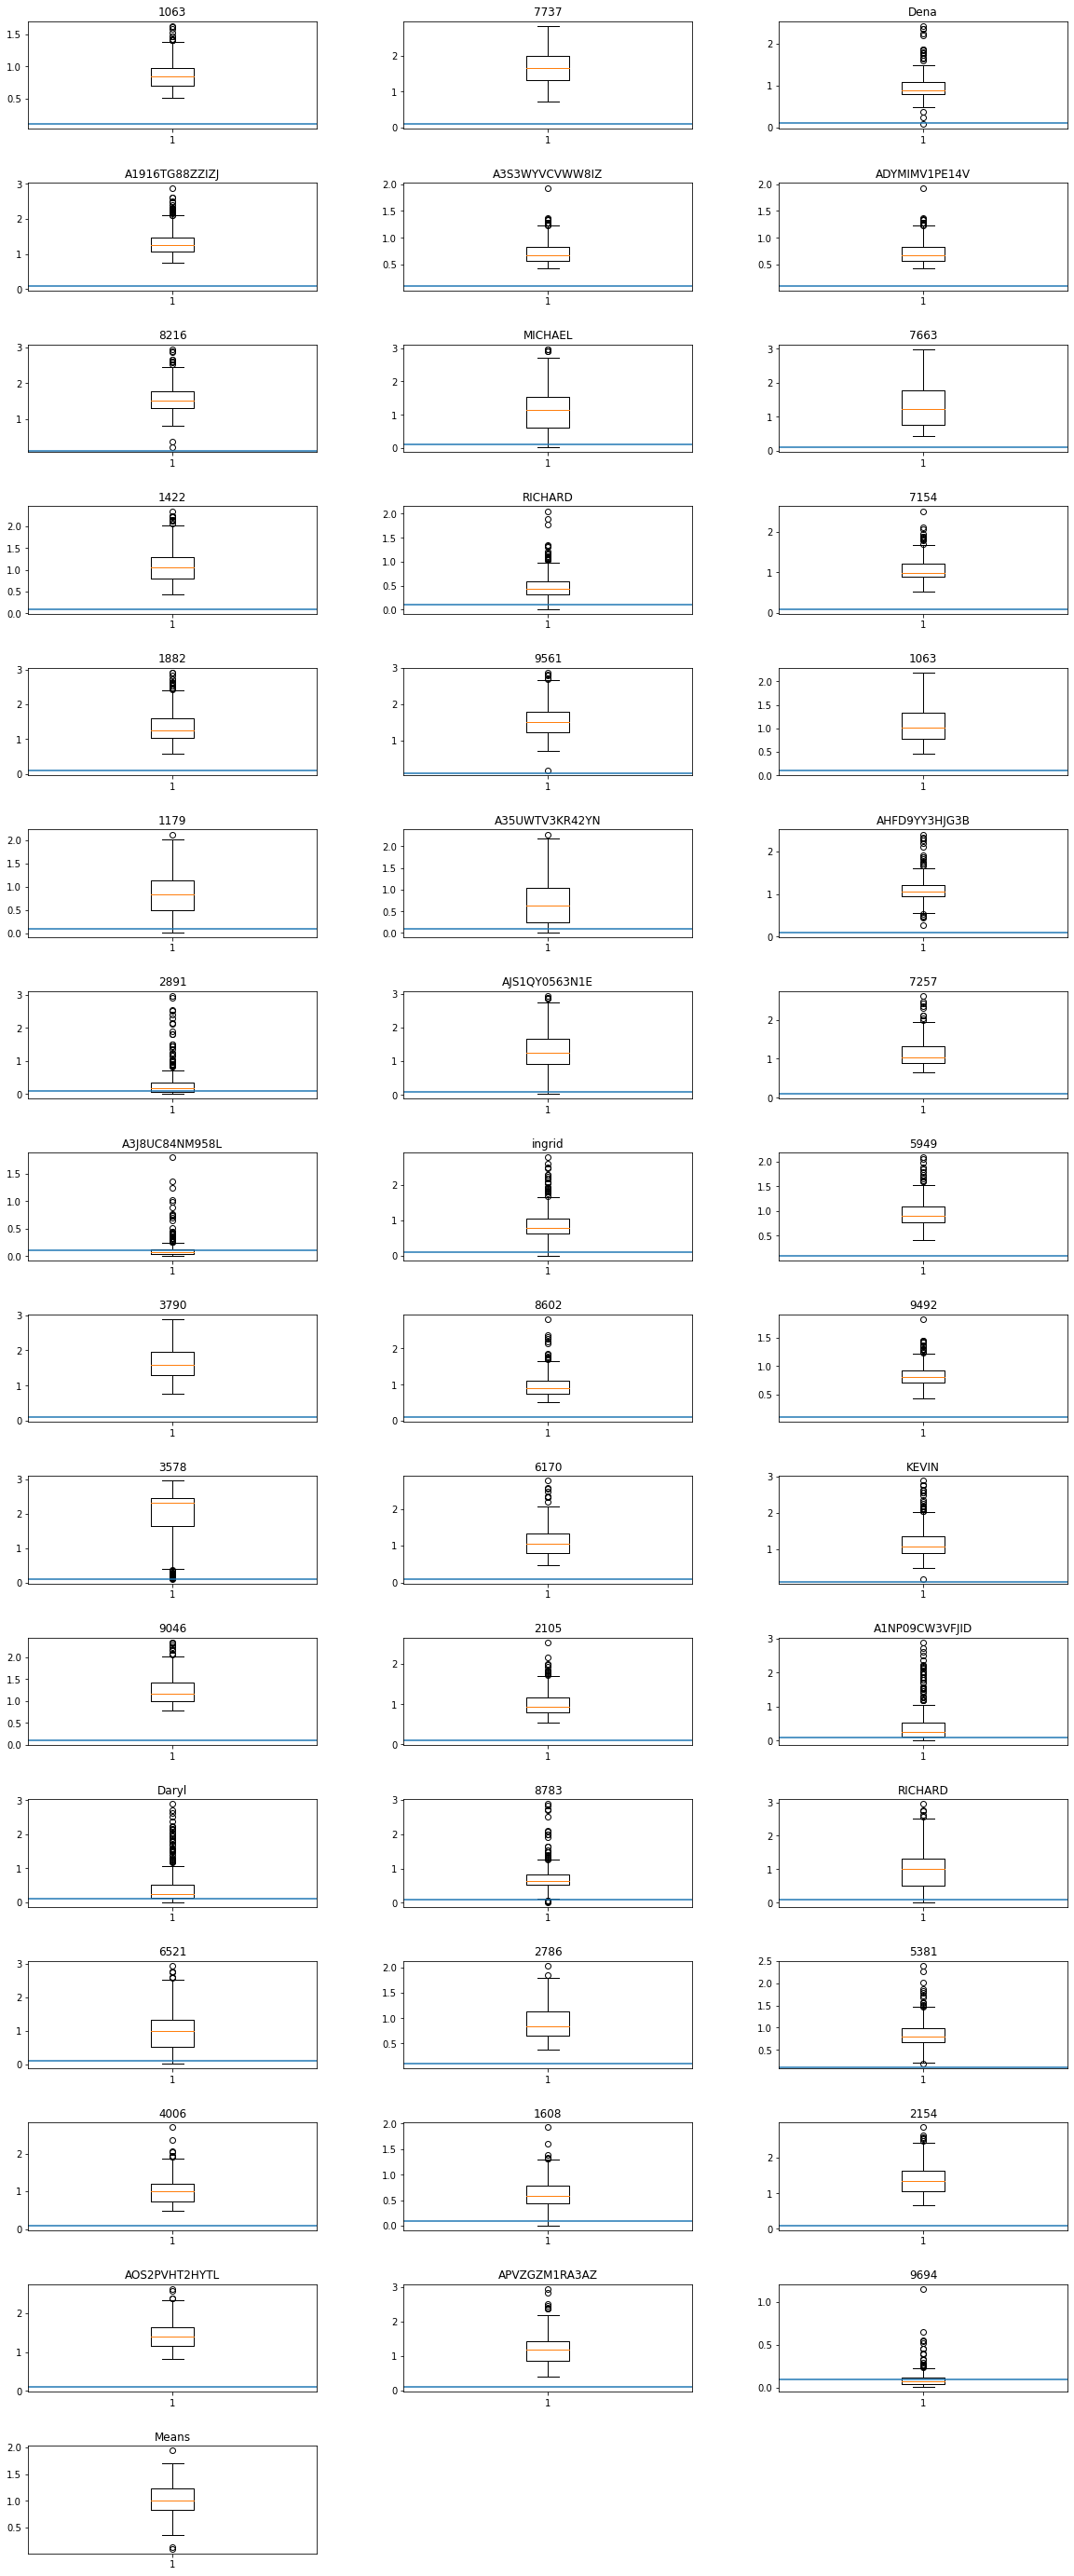

In [7]:
# Plot boxplots of the RTs.
fig = plt.figure(figsize=(20, 50))
cols = 3
rows = int(np.ceil(len(sorted_data)/cols)) + 1

counter = 1
num_failiures = {}
means = []

# Plot histograms for each subjects' RT.
for subject_data, subject_file in zip(sorted_data, sorted_files):
    
    try:
        response_times = subject_data["Input_selection.rt"].tolist()
    except:
        print(f"{subject_file} does not have response times.")
    
    # Each entry is in string brackets--remove and convert to floats.
    converted_response_times = []
    for i in range(len(response_times)):
        
        try:
            converted_response_times.append(float(response_times[i][1:-1]))
        except:
            # Record the number of failiures to record response times.
            if subject_file in num_failiures.keys():
                num_failiures[subject_file] = num_failiures[subject_file] + 1
            else:
                num_failiures[subject_file] = 1
            
    
    # Plot the subject's RT histogram.
    fig.add_subplot(rows, cols, counter)
    counter += 1
    plt.boxplot(converted_response_times)
    plt.title(subject_file.split("_")[0])
    plt.axhline(y=0.1) # Olympic T&F RT standard.
    
    # Recod the subjects' mean RT.
    means.append(np.mean(converted_response_times))
    
# Plot the means.
fig.add_subplot(rows, cols, counter)
counter += 1
plt.boxplot(means)
plt.title("Means")
plt.subplots_adjust(hspace=0.5, wspace=0.3)

Text(0.5, 1.0, 'RT failiures per subject')

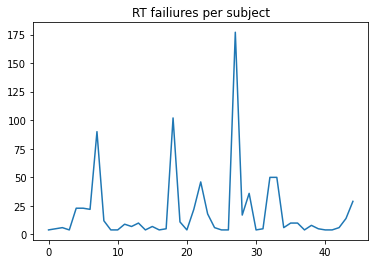

In [8]:
# Plot the number of failiures per subject.
plt.plot(num_failiures.values())
plt.title("RT failiures per subject")

## Quantify Missed Attention Checks

Text(0.5, 1.0, 'Distribution of correct attention checks')

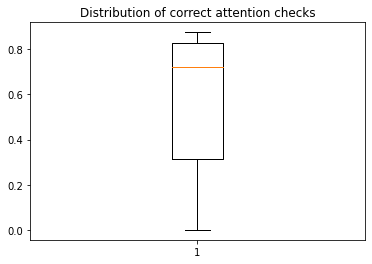

In [9]:
# Plot boxplot of the correct ATs.
proportion_correct_attention_checks = []
for subject_data, subject_file in zip(sorted_data, sorted_files):
    
    # Wether there was an attention check and response.
    try:
        was_attention_check = subject_data["Was_attention_check"]
        attention_check_response = subject_data["Attention_check.corr"]
    except:
        print(f"{subject_file} does not have attention checks.")
        
    assert len(was_attention_check) == len(attention_check_response), "Different number of responses and check."
    
    # Check successes and failiures.
    num_correct = 0
    num_total = 0
    for check, response in zip(was_attention_check, attention_check_response):
        
        if check:
            num_total += 1
            
            if not np.isnan(response) and int(response) == 1:
                num_correct += 1
                
    proportion_correct_attention_checks.append(num_correct/num_total)
    
plt.boxplot(proportion_correct_attention_checks)
plt.title("Distribution of correct attention checks")

## Remove Subjects/Trials for QA
Criteria:
- Subjects with mean RT below threshold (100ms).
- Trials from other subjects with RT less than threshold (100ms).
- Subjects with less than threshold (50%) correct attention checks.

In [10]:
rt_threshold = 0.1
ac_threshold = 0.5

In [11]:
# Go through each subjects data, sorting based on attention check criteria.
ac_sorted_data = []
for subject_data, subject_file in zip(sorted_data, sorted_files):
    
    # Wether there was an attention check and response.
    try:
        was_attention_check = subject_data["Was_attention_check"]
        attention_check_response = subject_data["Attention_check.corr"]
    except:
        print(f"{subject_file} does not have attention checks.")
        
    assert len(was_attention_check) == len(attention_check_response), "Different number of responses and check."
    
    # Check successes and failiures.
    num_correct = 0
    num_total = 0
    for check, response in zip(was_attention_check, attention_check_response):
        
        if check:
            num_total += 1
            
            if not np.isnan(response) and int(response) == 1:
                num_correct += 1
                
    proportion_correct_attention_checks = num_correct/num_total
    
    if proportion_correct_attention_checks > ac_threshold:
        
        ac_sorted_data.append(subject_data)

In [12]:
# Go through each subjects data, sorting based on response time criteria.
ac_rt_sorted_data = []
nun_failiures = {}
for subject_data in ac_sorted_data:
    
    try:
        response_times = subject_data["Input_selection.rt"].tolist()
    except:
        print(f"subject does not have response times.")
    
    # Each entry is in string brackets--remove and convert to floats.
    converted_response_times = []
    for i in range(len(response_times)):
        
        try:
            converted_response_times.append(float(response_times[i][1:-1]))
        except:
            # An empty trial--no response.
            pass
        
    if np.mean(converted_response_times) > rt_threshold:
        
        ac_rt_sorted_data.append(subject_data)

In [13]:
# Now pool all trials and remove those that were too quick.
# Make blank DF for adding rows.
pooled_sorted_data = pd.DataFrame(columns=subject_data.columns.tolist())
for subject_data in ac_rt_sorted_data:
    
    for trial in subject_data.T:
        
        trial_row = subject_data.T[trial]
        
        # Get the RT.
        try:
            response_time = trial_row["Input_selection.rt"]
        except:
            pass
        
        # Convert to number.
        try:
            converted_response_time = float(response_time[1:-1])
        except:
            pass
        
        # Only add the trial if RT is large enough.
        if converted_response_time > rt_threshold:

            pooled_sorted_data.loc[len(pooled_sorted_data.index)] = trial_row.tolist()

## Performance Tests
                       RT       Performance
                 ----------------------------
    SOS Fixed    |             |            |
    SOS Flexible |             |            |
                 ----------------------------
                 
                       RT       Performance
                  ----------------------------
    SOS Foreground|             |            |
    SOS Random    |             |            |
                  ----------------------------

In [15]:
# Collect trials corresponding to various single-object conditions.
MOS_fixed = pd.DataFrame(columns=subject_data.columns.tolist())
MOS_flexible = pd.DataFrame(columns=subject_data.columns.tolist())
SOS_foreground = pd.DataFrame(columns=subject_data.columns.tolist())
SOS_random = pd.DataFrame(columns=subject_data.columns.tolist())

for trial in pooled_sorted_data.T:
    
    trial_row = pooled_sorted_data.T[trial]
    
    # Fixed versus flexible.
    if trial_row["multi_object_rotation"] == "fixed":
        
        MOS_fixed.loc[len(MOS_fixed.index)] = trial_row.tolist()

    elif trial_row["multi_object_rotation"] == "flexible":
        
        MOS_flexible.loc[len(MOS_flexible.index)] = trial_row.tolist()
        
    # Foreground versus random.
    if trial_row["single_is_foreground_or_random"] == "foreground":
        
        SOS_foreground.loc[len(SOS_foreground.index)] = trial_row.tolist()

    elif trial_row["single_is_foreground_or_random"] == "random":
        
        SOS_random.loc[len(SOS_random.index)] = trial_row.tolist()

### RT

Ttest_indResult(statistic=-1.6471665833839946, pvalue=0.09955692875642957)
Indicates that rotation of the MOS does not impact RT.


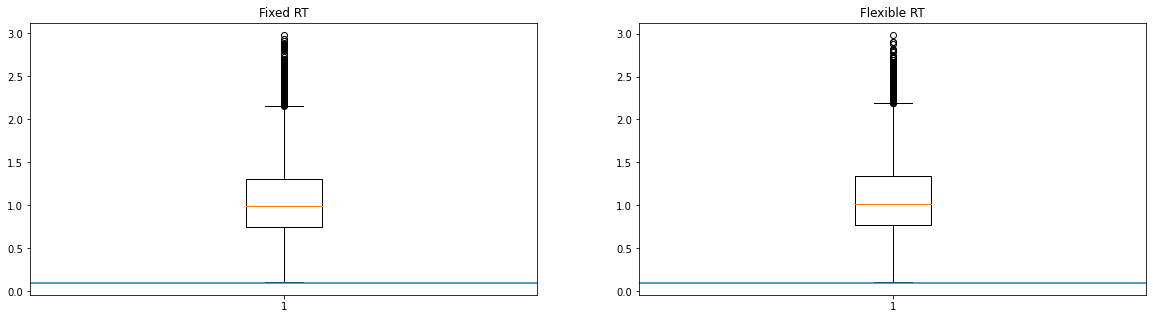

In [16]:
# Plot performance and RTs for each condition.
# Start with fixed/flexible.
fig = plt.figure(figsize=(20, 5))
cols = 2
rows = 1

fixed_RTs = MOS_fixed["Input_selection.rt"].tolist()

# Each entry is in string brackets--remove and convert to floats.
converted_fixed_RTs = []
for i in range(len(fixed_RTs)):

    try:
        converted_fixed_RTs.append(float(fixed_RTs[i][1:-1]))
    except:
        pass
    
flexible_RTs = MOS_flexible["Input_selection.rt"].tolist()

# Each entry is in string brackets--remove and convert to floats.
converted_flexible_RTs = []
for i in range(len(flexible_RTs)):

    try:
        converted_flexible_RTs.append(float(flexible_RTs[i][1:-1]))
    except:
        pass
    
fig.add_subplot(rows, cols, 1)
plt.boxplot(converted_fixed_RTs)
plt.title("Fixed RT")
plt.axhline(y=0.1)

fig.add_subplot(rows, cols, 2)
plt.boxplot(converted_flexible_RTs)
plt.title("Flexible RT")
plt.axhline(y=0.1)

print(sc.stats.ttest_ind(converted_fixed_RTs, converted_flexible_RTs, equal_var=False))
print("Indicates that rotation of the MOS does not impact RT.")

Ttest_indResult(statistic=-5.144892626441423, pvalue=2.7303170334667517e-07)
Indicates whether the SOS is the same as foreground in MOS or random impacts RT.


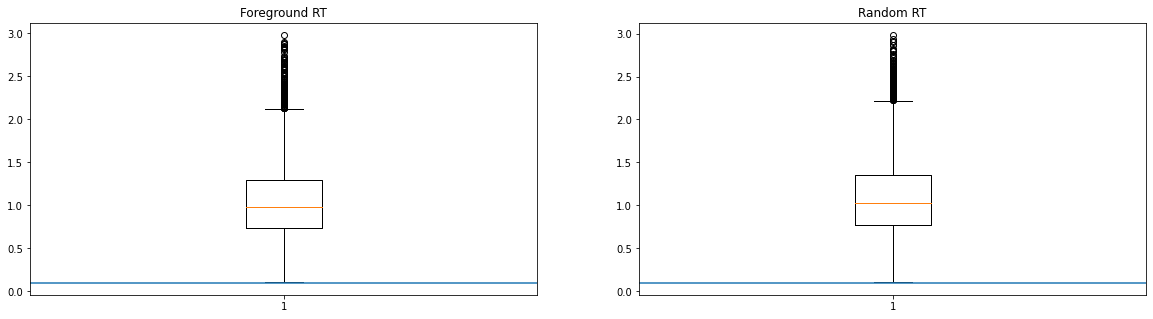

In [17]:
# Now foreground/random.
fig = plt.figure(figsize=(20, 5))
cols = 2
rows = 1

foreground_RTs = SOS_foreground["Input_selection.rt"].tolist()

# Each entry is in string brackets--remove and convert to floats.
converted_foreground_RTs = []
for i in range(len(foreground_RTs)):

    try:
        converted_foreground_RTs.append(float(foreground_RTs[i][1:-1]))
    except:
        pass
    
random_RTs = SOS_random["Input_selection.rt"].tolist()

# Each entry is in string brackets--remove and convert to floats.
converted_random_RTs = []
for i in range(len(random_RTs)):

    try:
        converted_random_RTs.append(float(random_RTs[i][1:-1]))
    except:
        pass
    
fig.add_subplot(rows, cols, 1)
plt.boxplot(converted_foreground_RTs)
plt.title("Foreground RT")
plt.axhline(y=0.1)

fig.add_subplot(rows, cols, 2)
plt.boxplot(converted_random_RTs)
plt.title("Random RT")
plt.axhline(y=0.1)

print(sc.stats.ttest_ind(converted_foreground_RTs, converted_random_RTs, equal_var=False))
print("Indicates whether the SOS is the same as foreground in MOS or random impacts RT.")

### Performance

In [20]:
# Calculate performance for each subject to get a distribution.

# Get the ball rolling.
curr_subj_id = MOS_fixed["participant"].tolist()[0]
fixed_performances = []
flexible_performances = []

# Fixed.
fixed_num_rows = 0
fixed_num_correct = 0

for i in range(len(MOS_fixed)):
    
    if MOS_fixed["participant"].tolist()[i] == curr_subj_id:
        
        curr_subj_id = MOS_fixed["participant"].tolist()[i]

        trial_row = MOS_fixed.loc[i]

        if is_correct(trial_row) == 0:

            pass

        elif is_correct(trial_row) == 1:

            fixed_num_rows += 1
            fixed_num_correct += 1

        elif is_correct(trial_row) == 2:

            fixed_num_rows += 1
        
    else:

        curr_subj_id = MOS_fixed["participant"].tolist()[i]
        fixed_performances.append(fixed_num_correct/fixed_num_rows)
        
        # Reset.
        fixed_num_rows = 0
        fixed_num_correct = 0
            
# Get the last one.
fixed_performances.append(fixed_num_correct/fixed_num_rows)
            
# Flexible.      
# Get the ball rolling.
curr_subj_id = MOS_flexible["participant"].tolist()[0]

# Flexible.
flexible_num_rows = 0
flexible_num_correct = 0

for i in range(len(MOS_flexible)):
    
    if MOS_flexible["participant"].tolist()[i] == curr_subj_id:
        
        curr_subj_id = MOS_flexible["participant"].tolist()[i]

        trial_row = MOS_flexible.loc[i]

        if is_correct(trial_row) == 0:

            pass

        elif is_correct(trial_row) == 1:

            flexible_num_rows += 1
            flexible_num_correct += 1

        elif is_correct(trial_row) == 2:

            flexible_num_rows += 1
        
    else:

        curr_subj_id = MOS_flexible["participant"].tolist()[i]
        flexible_performances.append(flexible_num_correct/flexible_num_rows)
        
        # Reset.
        flexible_num_rows = 0
        flexible_num_correct = 0
            
# Get the last one.
flexible_performances.append(flexible_num_correct/flexible_num_rows)

Ttest_indResult(statistic=-1.2356660691592625, pvalue=0.2228872951773715)


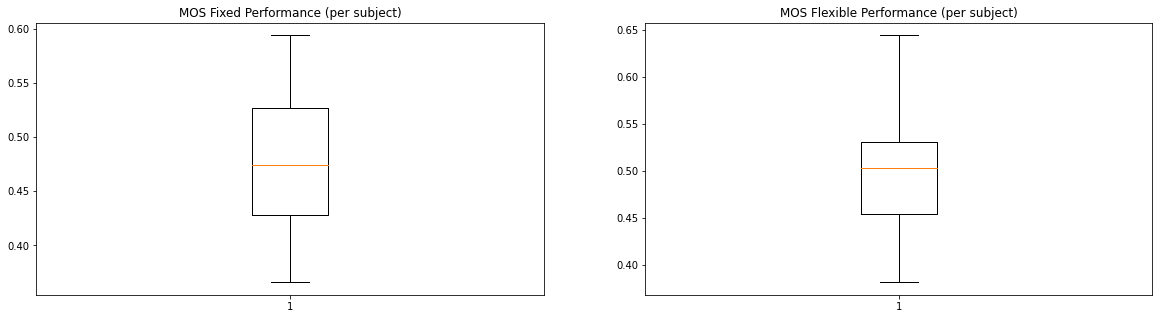

In [21]:
# Now plot.
fig = plt.figure(figsize=(20, 5))
cols = 2
rows = 1

fig.add_subplot(rows, cols, 1)
plt.boxplot(fixed_performances)
plt.title("MOS Fixed Performance (per subject)")

fig.add_subplot(rows, cols, 2)
plt.boxplot(flexible_performances)
plt.title("MOS Flexible Performance (per subject)")

print(sc.stats.ttest_ind(fixed_performances, flexible_performances, equal_var=False))

In [22]:
# SOS foreground or random.

# Get the ball rolling.
curr_subj_id = SOS_foreground["participant"].tolist()[0]
foreground_performances = []
random_performances = []

# Foreground.
foreground_num_rows = 0
foreground_num_correct = 0

for i in range(len(SOS_foreground)):
    
    if SOS_foreground["participant"].tolist()[i] == curr_subj_id:
        
        curr_subj_id = SOS_foreground["participant"].tolist()[i]

        trial_row = SOS_foreground.loc[i]

        if is_correct(trial_row) == 0:

            pass

        elif is_correct(trial_row) == 1:

            foreground_num_rows += 1
            foreground_num_correct += 1

        elif is_correct(trial_row) == 2:

            foreground_num_rows += 1
        
    else:

        curr_subj_id = SOS_foreground["participant"].tolist()[i]
        foreground_performances.append(foreground_num_correct/foreground_num_rows)
        
        # Reset.
        foreground_num_rows = 0
        foreground_num_correct = 0
            
# Get the last one.
foreground_performances.append(foreground_num_correct/foreground_num_rows)
            
# Random.      
# Get the ball rolling.
curr_subj_id = SOS_random["participant"].tolist()[0]

# Random.
random_num_rows = 0
random_num_correct = 0

for i in range(len(SOS_random)):
    
    if SOS_random["participant"].tolist()[i] == curr_subj_id:
        
        curr_subj_id = SOS_random["participant"].tolist()[i]

        trial_row = SOS_random.loc[i]

        if is_correct(trial_row) == 0:

            pass

        elif is_correct(trial_row) == 1:

            random_num_rows += 1
            random_num_correct += 1

        elif is_correct(trial_row) == 2:

            random_num_rows += 1
        
    else:

        curr_subj_id = SOS_random["participant"].tolist()[i]
        random_performances.append(random_num_correct/random_num_rows)
        
        # Reset.
        random_num_rows = 0
        random_num_correct = 0
            
# Get the last one.
random_performances.append(random_num_correct/random_num_rows)

Ttest_indResult(statistic=-0.052837817479601354, pvalue=0.9580914843128698)


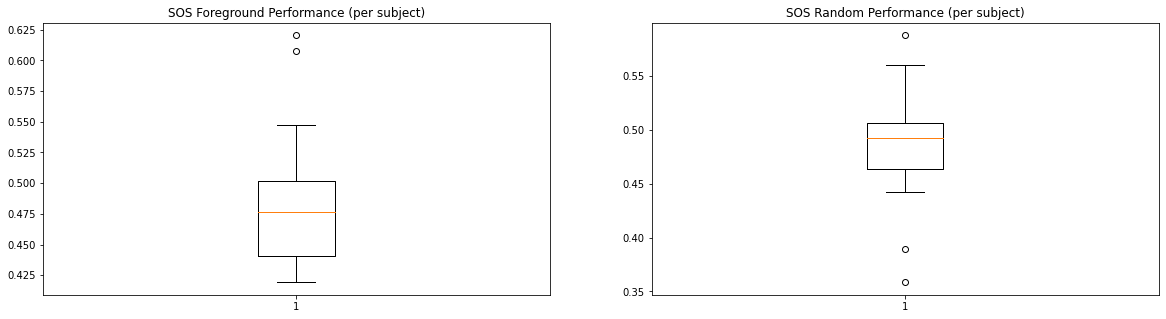

In [23]:
# Now plot.
fig = plt.figure(figsize=(20, 5))
cols = 2
rows = 1

fig.add_subplot(rows, cols, 1)
plt.boxplot(foreground_performances)
plt.title("SOS Foreground Performance (per subject)")

fig.add_subplot(rows, cols, 2)
plt.boxplot(random_performances)
plt.title("SOS Random Performance (per subject)")

print(sc.stats.ttest_ind(foreground_performances, random_performances, equal_var=False))

## Useful Functions

In [19]:
def is_correct(row):
    """
    Given a trial row from a dataframe, returns boolean of whether the answer is correct or not.
    
    Params:
    row: pandas series, row from dataframe.
    
    Returns: number indicating whether the answer is correct or nonresponsive (skip row).
    """
    if type(row["Input_selection.keys"]) != str:
        return 0
    
    answer = row["Input_selection.keys"][2:-2]
    corr_ans = row["location_of_correct_answer"]
    
    if answer == corr_ans:
        return 1
    
    else:
        return 2